In [1]:
import optuna
import random
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.problem_loaders.vrp_loader import VRPLoader
from src.algorithms.ga_vrp import GeneticAltorithmVRP
from src.algorithms.ant_system import AntSystem
from src.algorithms.ant_vrp import AntVRP
from src.plotting import plot_solution

# VRP with GA

In [4]:
PROBLEM_INSTANCE_NAME = 'tai100a'

vrp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = vrp_loader.load_problem_instance()
ga_trials = []
def objective(trial):
    params = {
        "mutation_rate" : trial.suggest_float("mutation_rate", 0.01, 0.9),
        "population_size" : trial.suggest_int("population_size", 10,60),
        "elitism_rate" : trial.suggest_float("elitism_rate", 0.01, 0.2),
        "max_generations" : trial.suggest_int("max_generations", 50, 400)
    }
    ga = GeneticAltorithmVRP(problem_instance, coordinates, demand, capacity, **params)
    ga_trials.append(ga)
    ga.run(trial)

    return np.min(ga.best_fitness_in_generation)

study = optuna.create_study(study_name=f"ga_{PROBLEM_INSTANCE_NAME}", storage=f"sqlite:///ga_{PROBLEM_INSTANCE_NAME}.db", load_if_exists=True, direction="minimize")
study.optimize(objective, n_trials=50)

[I 2022-11-26 22:03:03,843] A new study created in RDB with name: ga_tai100a


C:\Users\karst\AppData\Local\Temp\ipykernel_10944\1453091512.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:53: RuntimeWarning: invalid value encountered in divide
  unit_delta_x = delta_x / delta_length
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:54: RuntimeWarning: invalid value encountered in divide
  unit_delta_y = delta_y / delta_length
C:\Users\karst\AppData\Local\Temp\ipykernel_10944\1453091512.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\karst\AppData\Local\Temp\ipykernel_10944\1453091512.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:

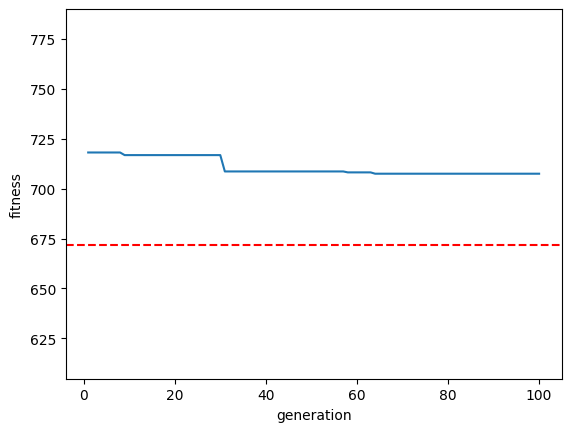

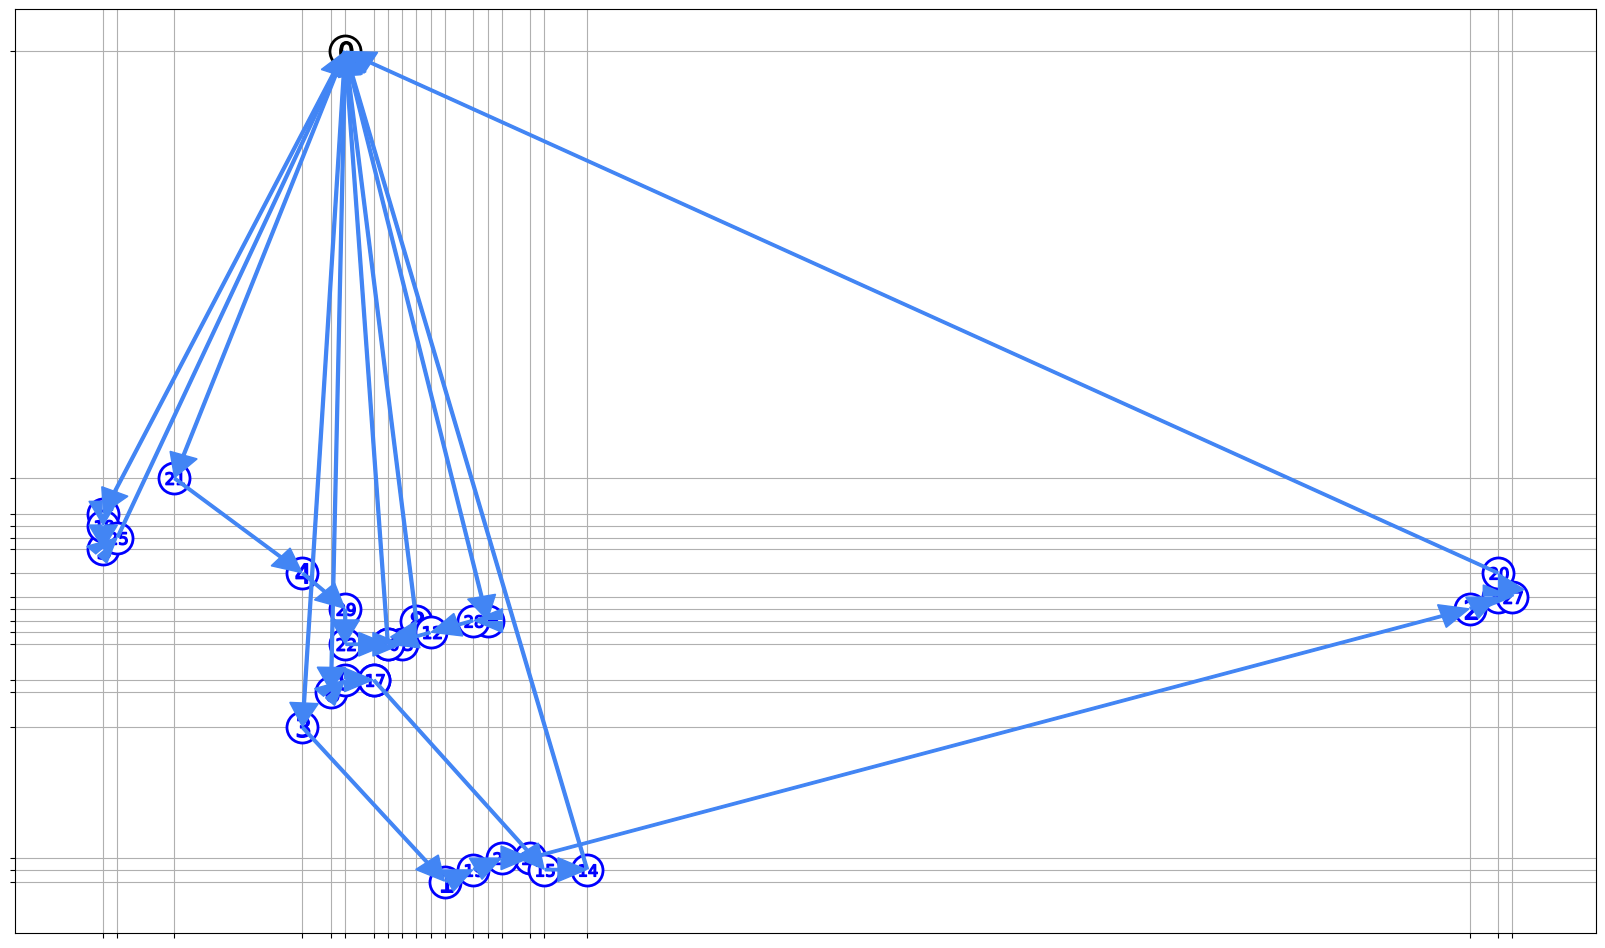

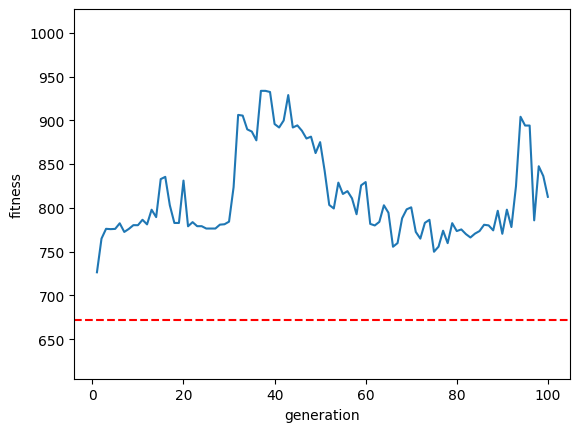

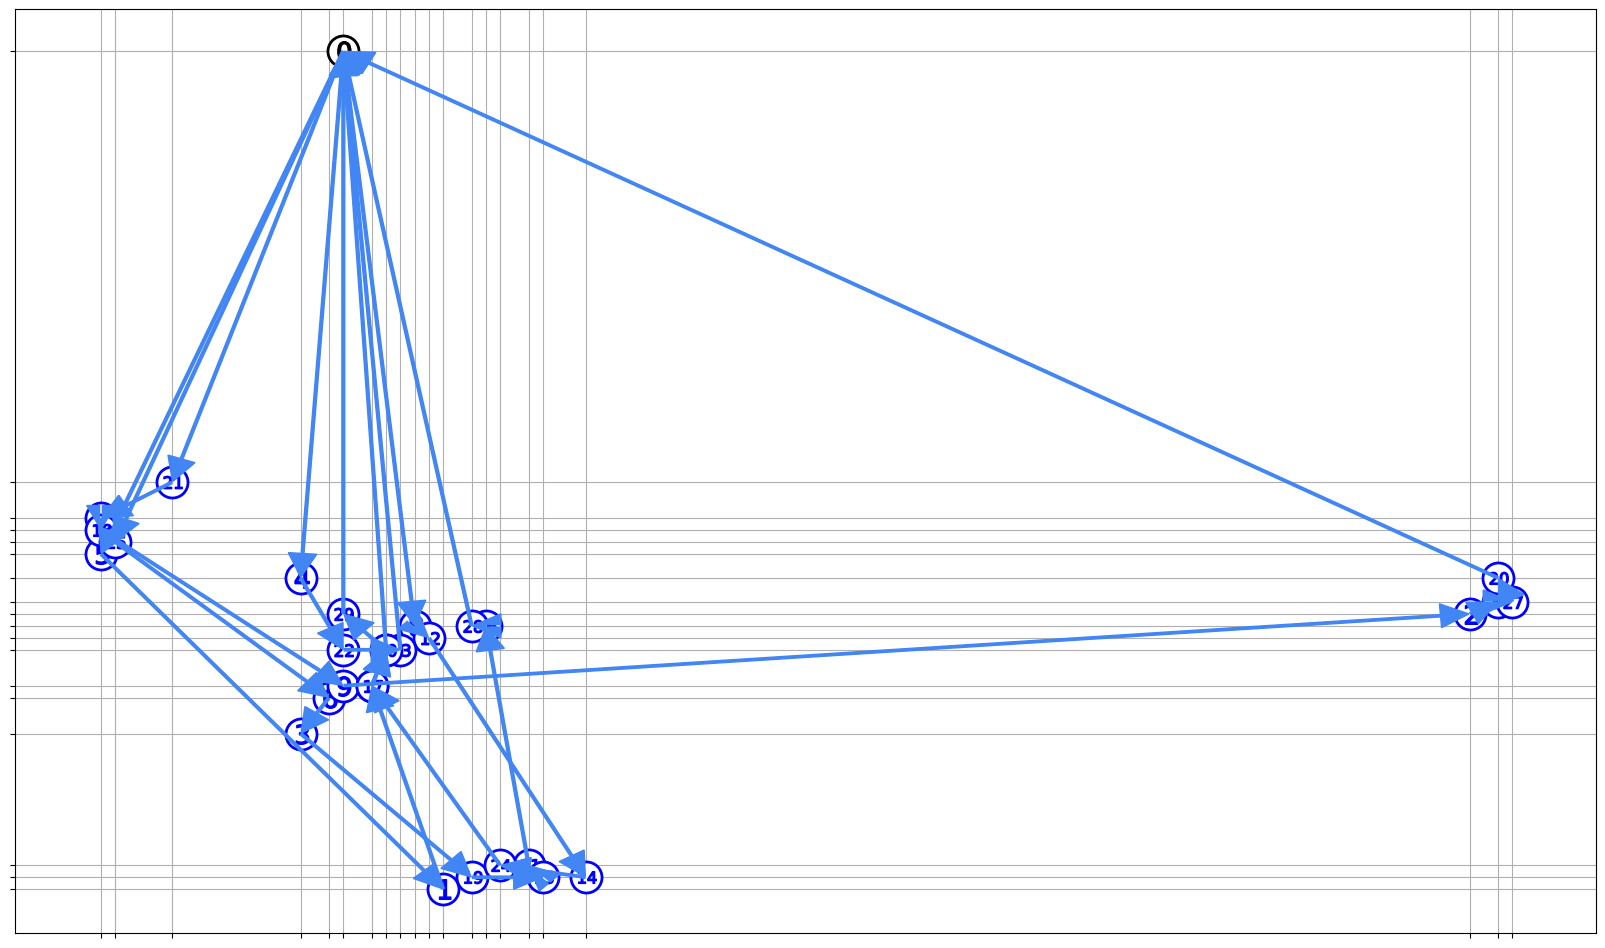

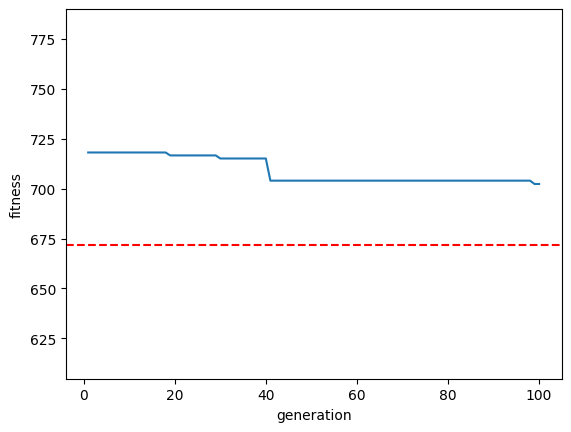

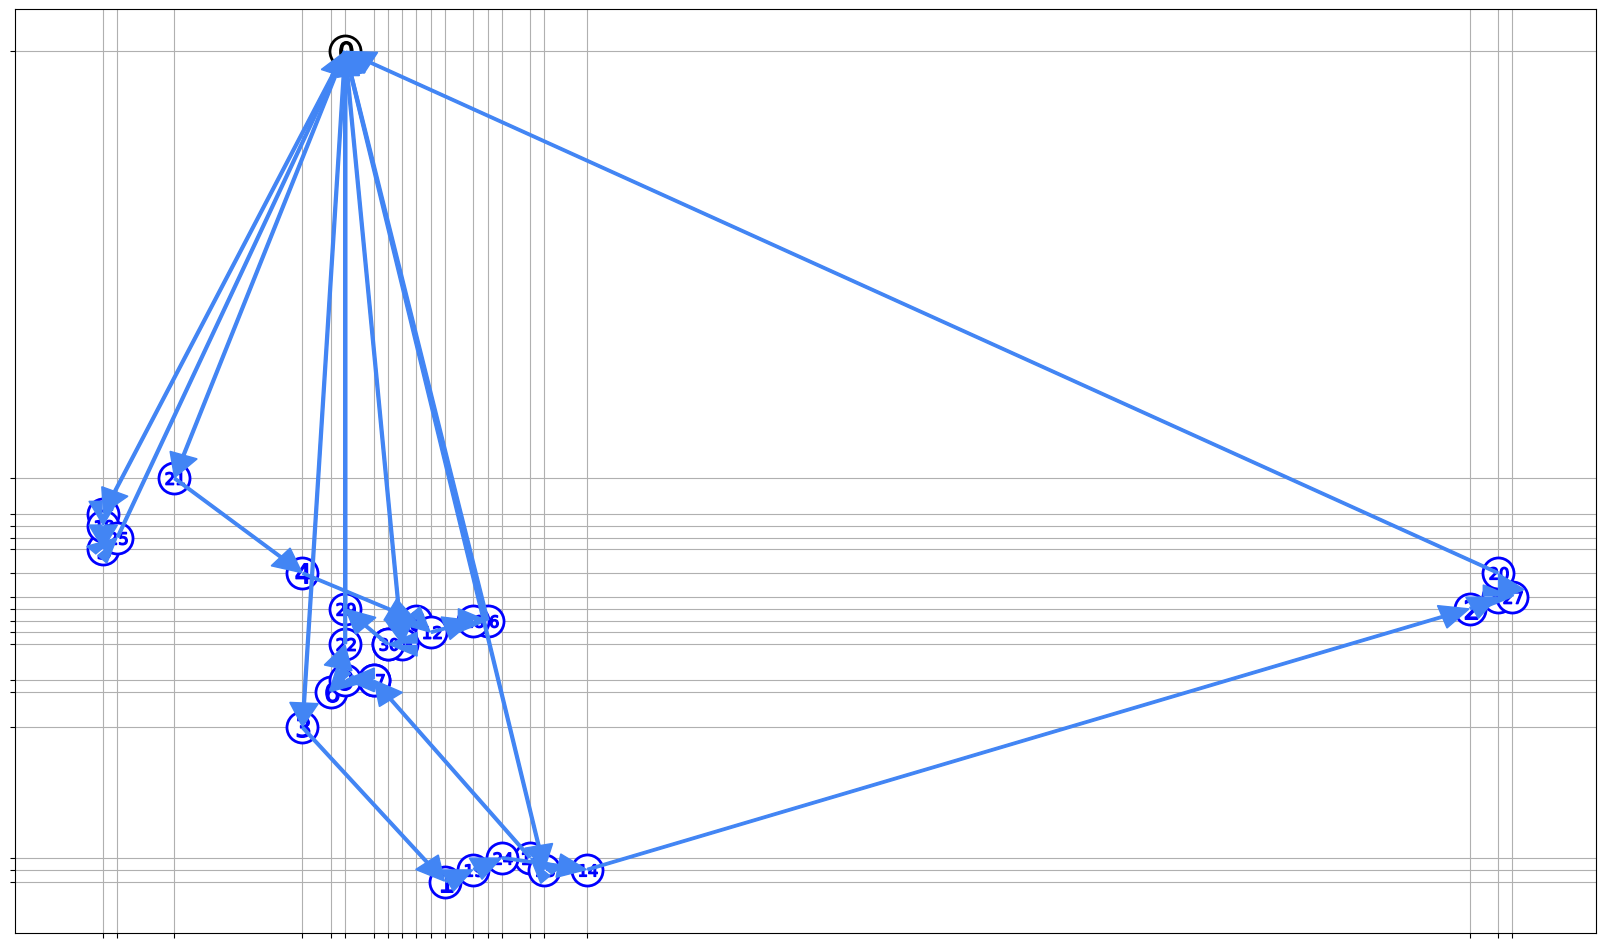

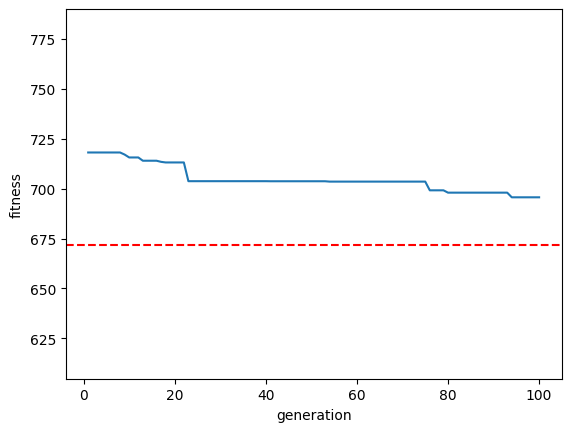

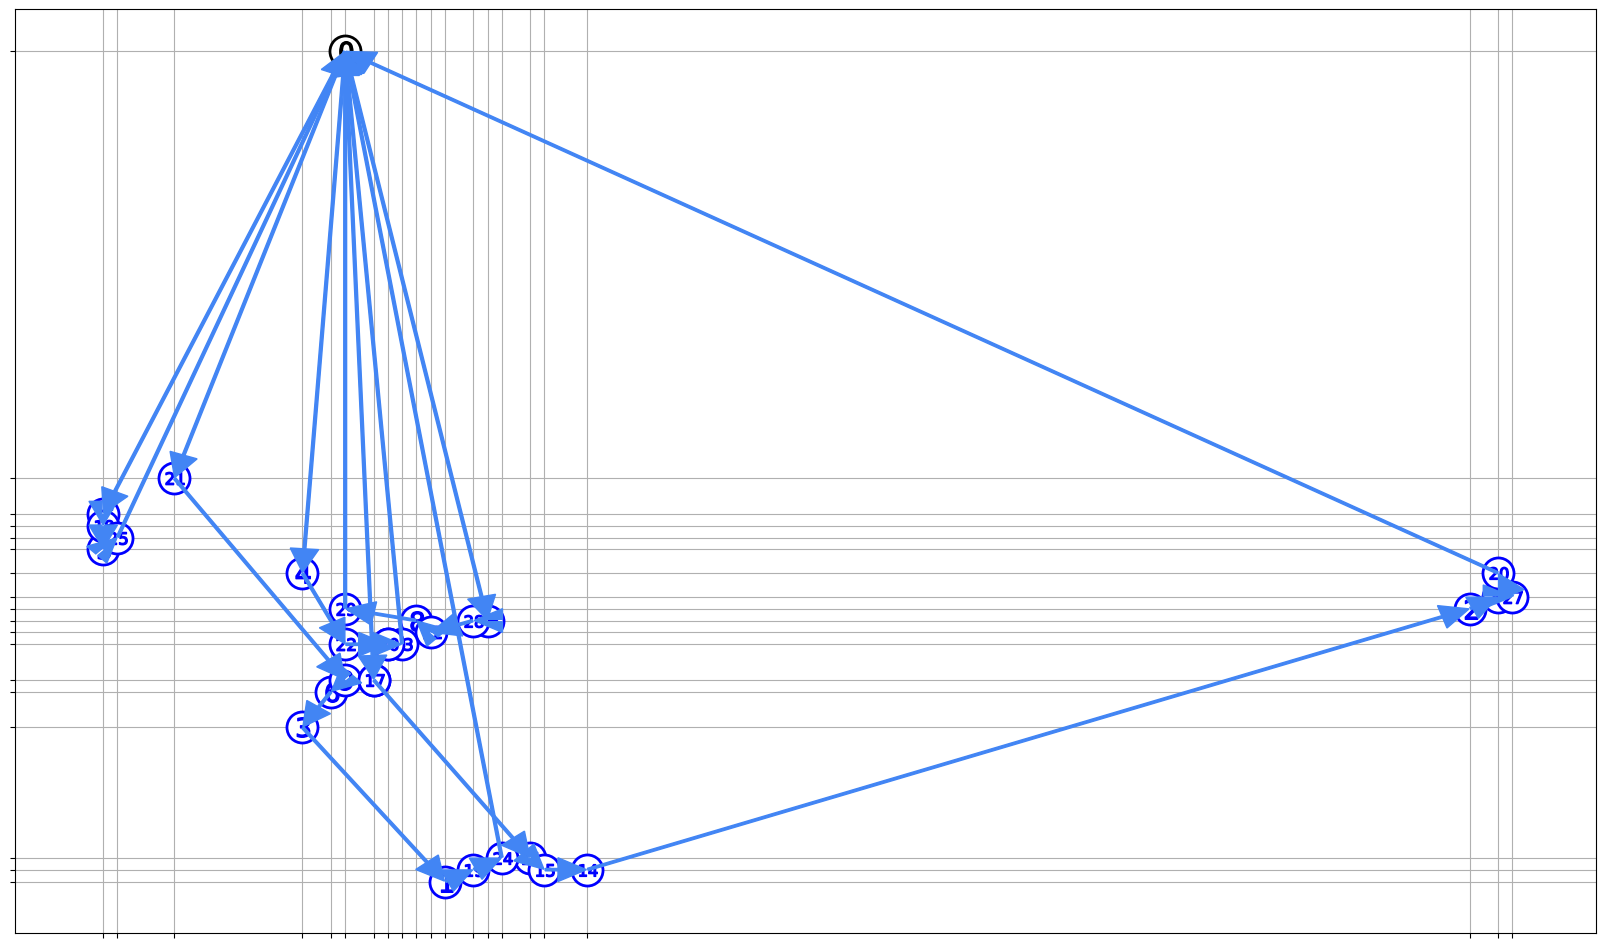

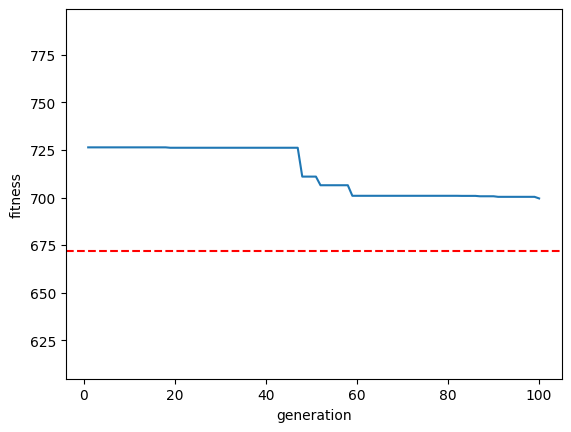

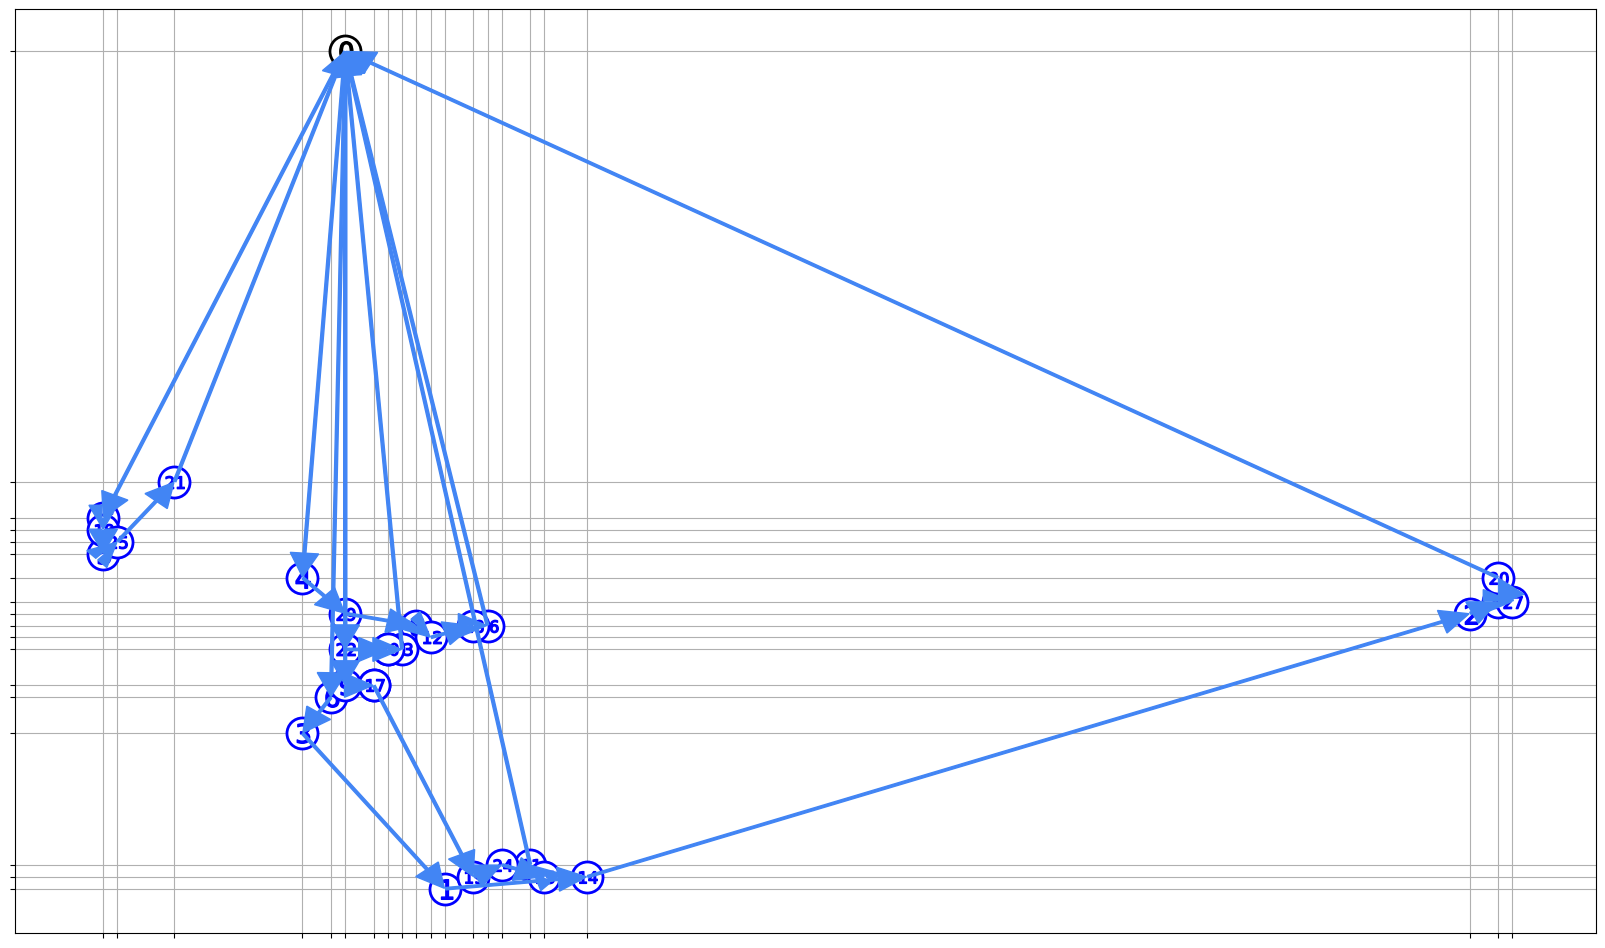

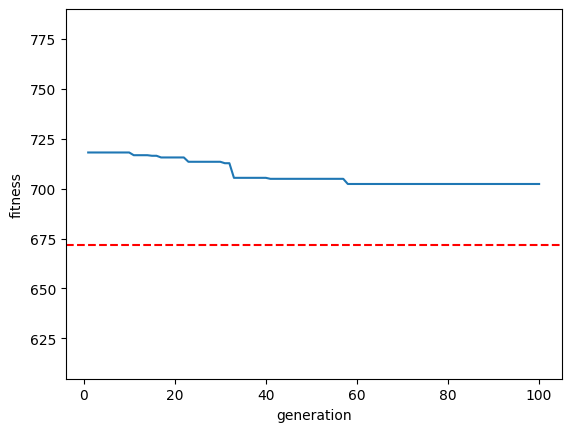

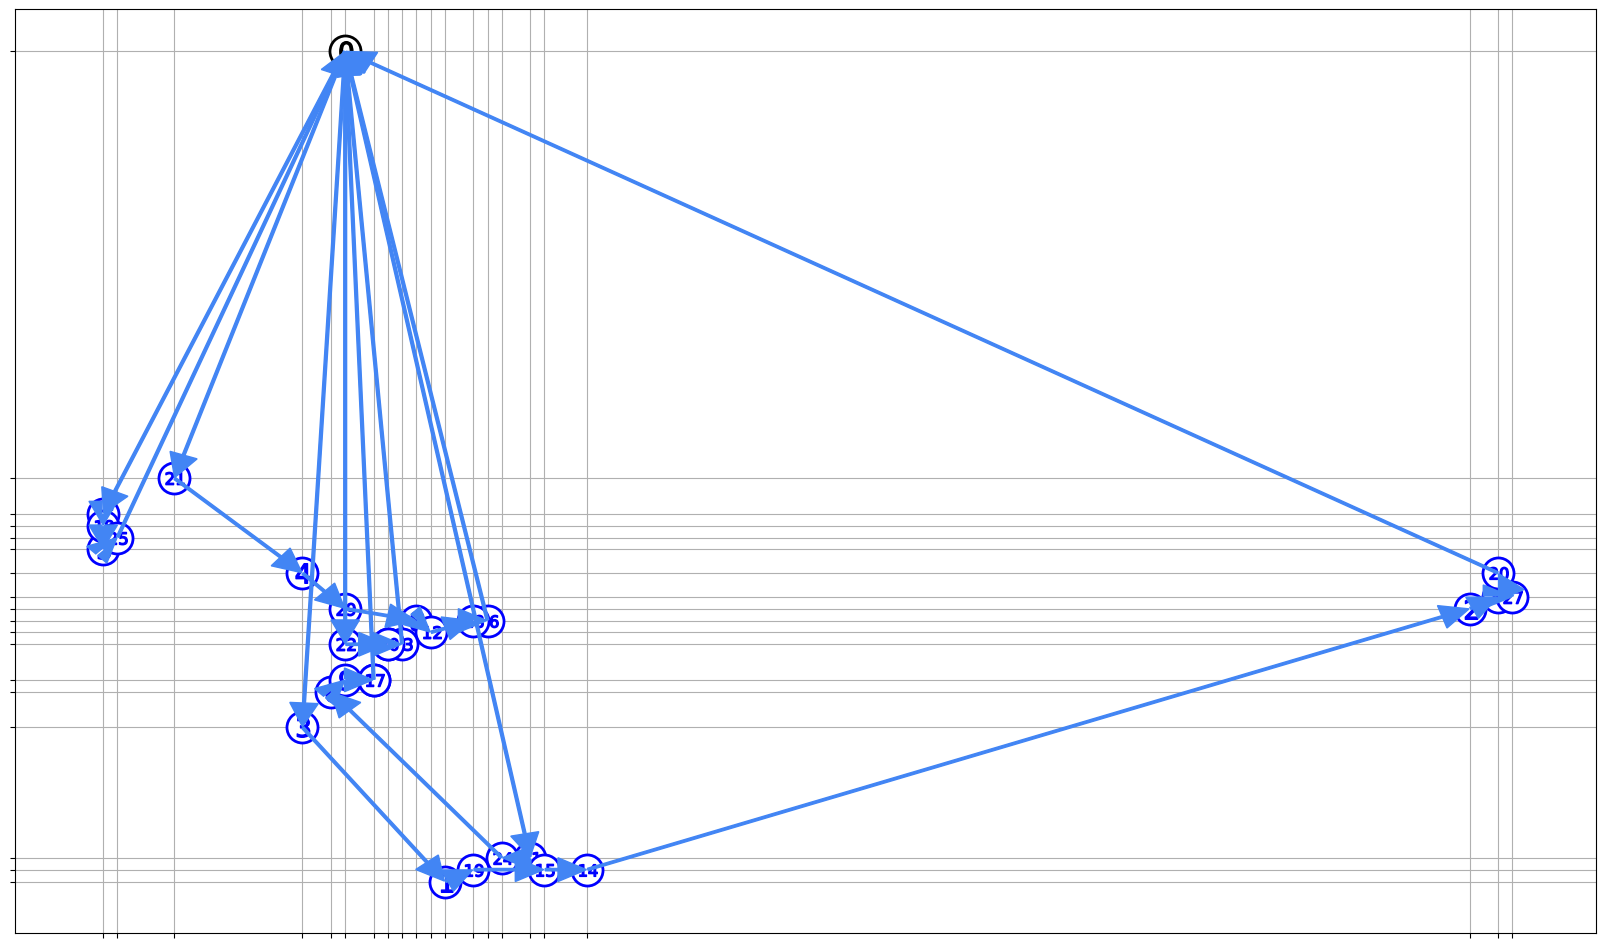

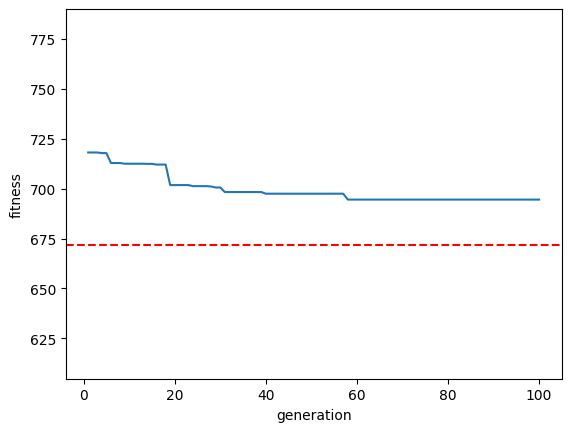

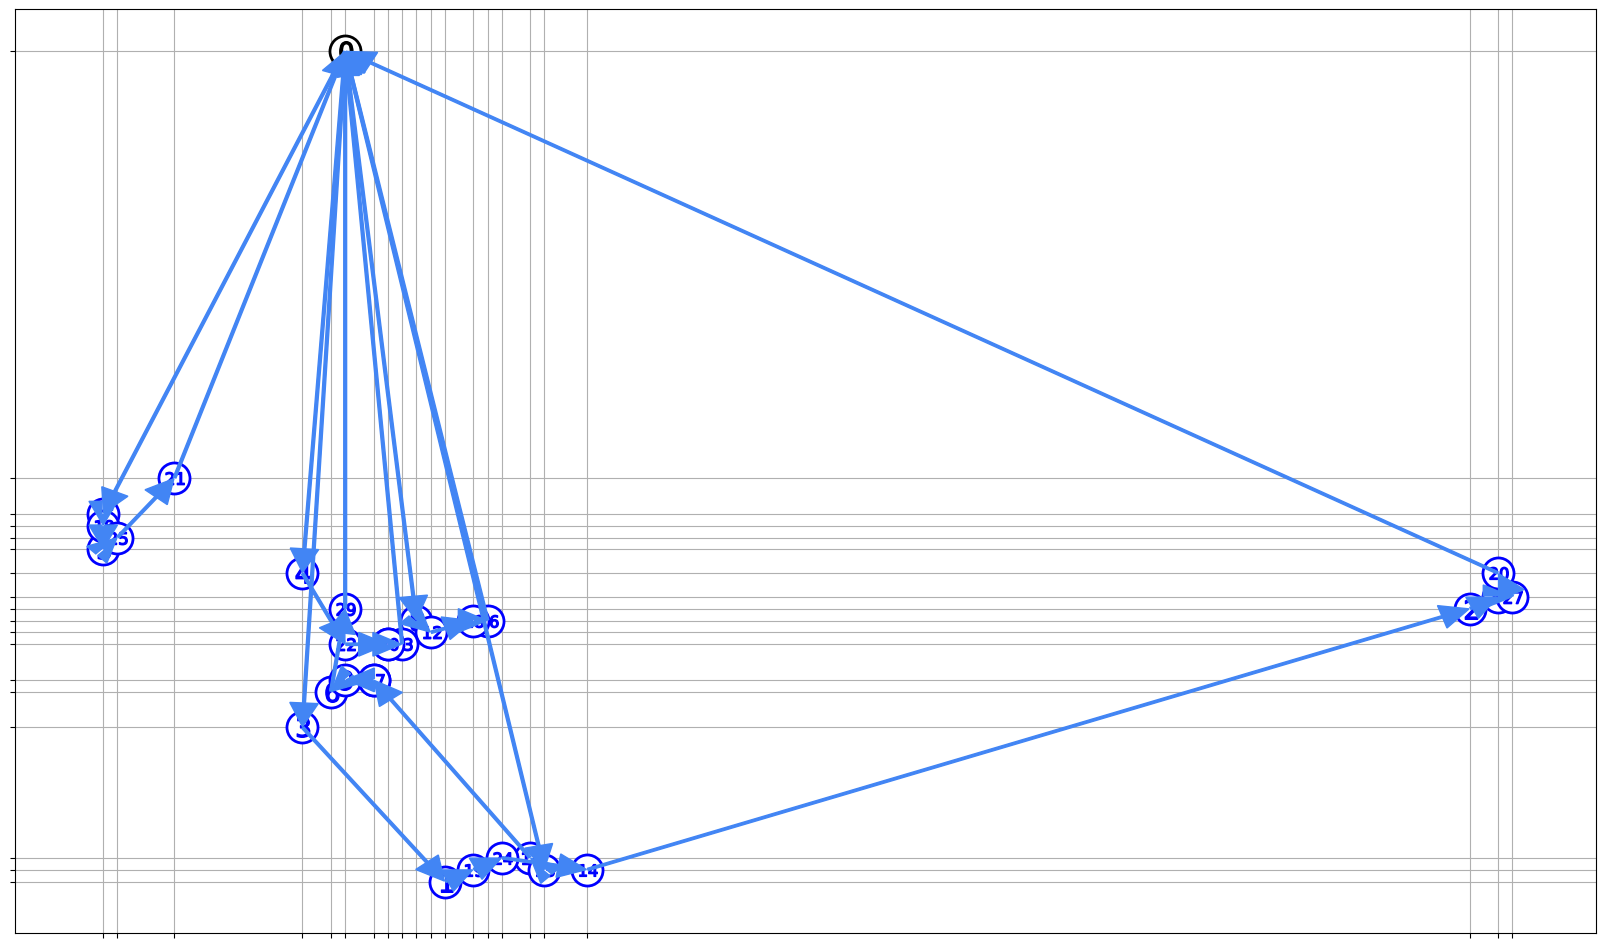

In [16]:
for trial, ga in enumerate(ga_trials):
    if study.get_trials()[trial].state == optuna.trial.TrialState.PRUNED:
        continue
   
    # plot training
    stats_df = ga.fitness_df()
    fig, ax = plt.subplots()
    chart = sns.lineplot(data=stats_df, x='generation', y='fitness', ax=ax)
    ax.set_ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
    chart.axhline(best_solution_cost, color='red', linestyle='--')
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}.pdf")
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}.png")
    fig.show()

    # plot paths
    best_path = ga._get_paths(ga.best_chromosome.chromosome)[0]
    single_path = list(itertools.chain.from_iterable(best_path)) + [0]
    fig = plot_solution(coordinates, single_path)
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}_path.pdf")
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}_path.png")
    fig.show()
    

# VRP with Ant System

In [2]:
PROBLEM_INSTANCE_NAME = "tai100a"#'X-n655-k131'

vrp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = vrp_loader.load_problem_instance()

as_trials = []
def as_objective(trial):
    params = {
        "number_of_ants" : trial.suggest_int("number_of_ants", 5, 400),
        "time" : trial.suggest_int("time", 20, 400),
        "visibility" : trial.suggest_categorical("visibility", ["distance", "saving_function"]),
        "trail_update" : trial.suggest_categorical("trail_update", ["all", "best", "elitist"]),
        "alpha" : trial.suggest_int("alpha", 1, 6),
        "beta" : trial.suggest_int("beta", 1,6),
        "evaporation_coefficient" : trial.suggest_float("evaporation_coefficient", 0.01, 0.9),
        "best_rate" : trial.suggest_float("best_rate", 0.05, 0.5),
        "candidate_ratio" : trial.suggest_float("candidate_ratio", 0.1, 1)
    }
    ant_system = AntSystem(AntVRP, problem_instance, demand=demand, capacity=capacity, debug_mode=False, **params)
    as_trials.append(ant_system)
    try:
        ant_system.run(trial)
        return np.min(ant_system.best_fitness_at_time_point)
    except ValueError:
        raise optuna.TrialPruned()

as_study = optuna.create_study(study_name=f"as_{PROBLEM_INSTANCE_NAME}", storage=f"sqlite:///as_{PROBLEM_INSTANCE_NAME}.db", load_if_exists=True, direction="minimize")




[I 2022-11-26 19:08:33,899] A new study created in RDB with name: as_tai100a


In [3]:
as_study.optimize(as_objective, n_trials=50)

Time Point: 100%|██████████| 23/23 [00:56<00:00,  2.47s/it]
[I 2022-11-26 19:09:36,231] Trial 0 finished with value: 3146.8053390565274 and parameters: {'number_of_ants': 261, 'time': 23, 'visibility': 'saving_function', 'trail_update': 'best', 'alpha': 2, 'beta': 5, 'evaporation_coefficient': 0.6600943504710046, 'best_rate': 0.40624301078508634, 'candidate_ratio': 0.7867383284808805}. Best is trial 0 with value: 3146.8053390565274.
Time Point: 100%|██████████| 182/182 [08:57<00:00,  2.95s/it]
[I 2022-11-26 19:18:34,810] Trial 1 finished with value: 2891.592365678451 and parameters: {'number_of_ants': 304, 'time': 182, 'visibility': 'distance', 'trail_update': 'best', 'alpha': 1, 'beta': 1, 'evaporation_coefficient': 0.4358807167056353, 'best_rate': 0.2317309688117425, 'candidate_ratio': 0.20438236051301883}. Best is trial 1 with value: 2891.592365678451.
Time Point: 100%|██████████| 397/397 [20:53<00:00,  3.16s/it]
[I 2022-11-26 19:39:29,734] Trial 2 finished with value: 2581.96890996

C:\Users\karst\AppData\Local\Temp\ipykernel_7816\712278992.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:53: RuntimeWarning: invalid value encountered in divide
  unit_delta_x = delta_x / delta_length
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:54: RuntimeWarning: invalid value encountered in divide
  unit_delta_y = delta_y / delta_length
C:\Users\karst\AppData\Local\Temp\ipykernel_7816\712278992.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\karst\AppData\Local\Temp\ipykernel_7816\712278992.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\Code\

Error in Trial 3
Error in Trial 7
Error in Trial 9


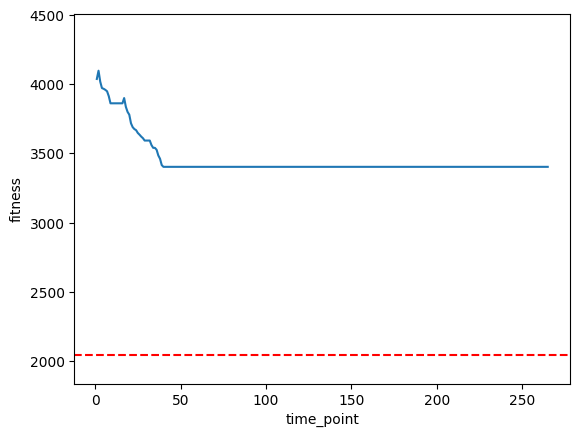

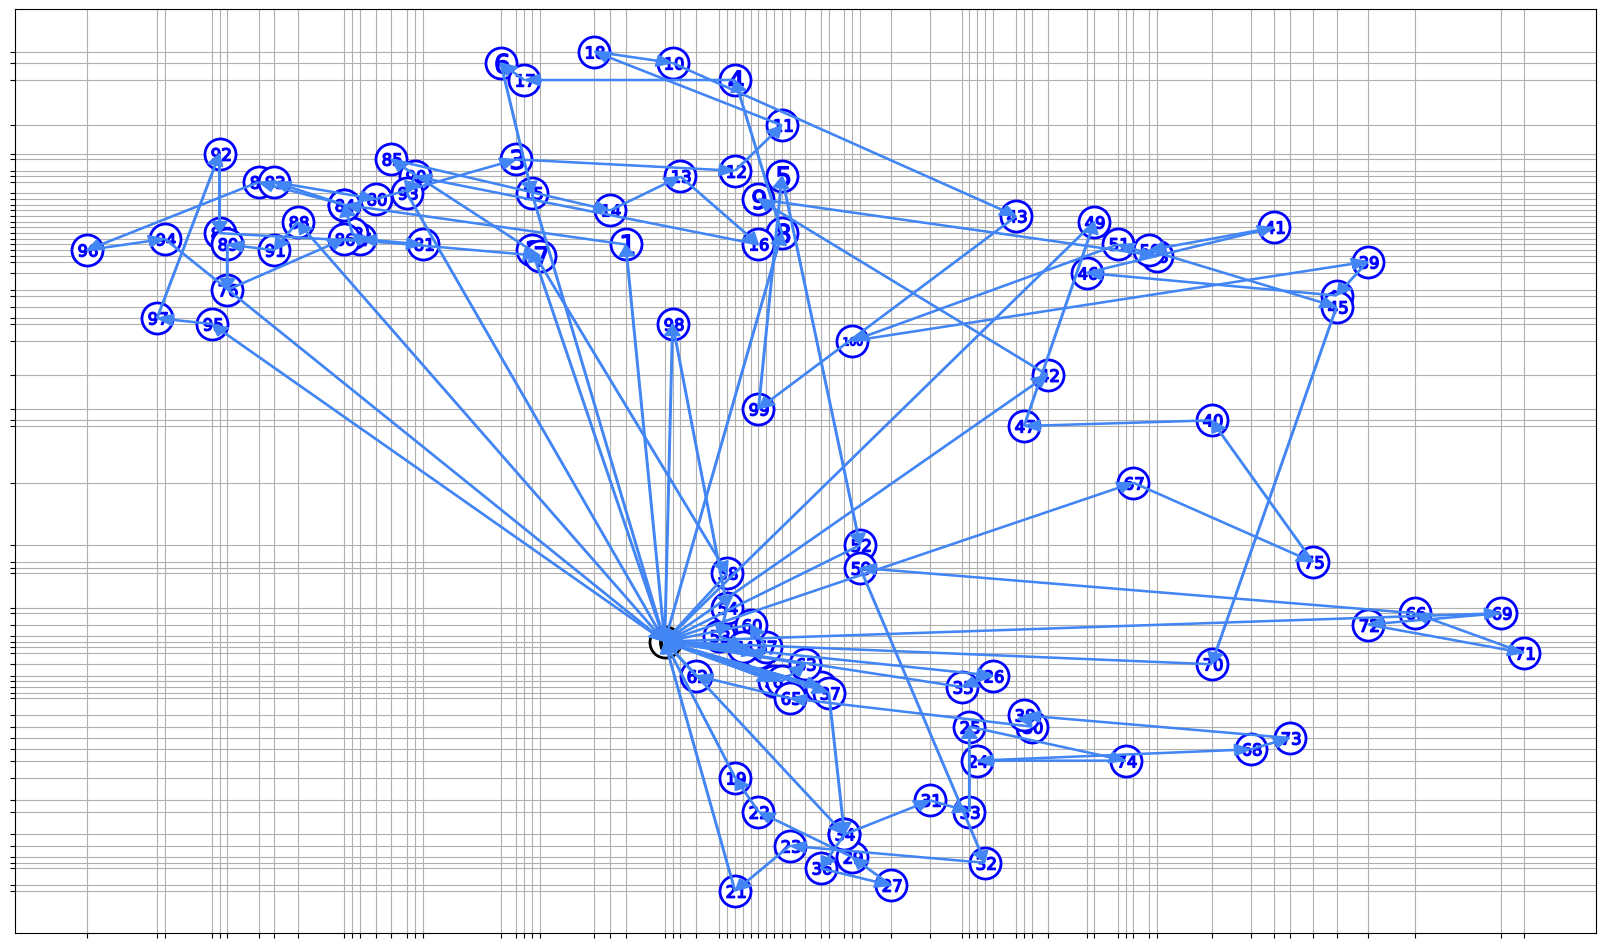

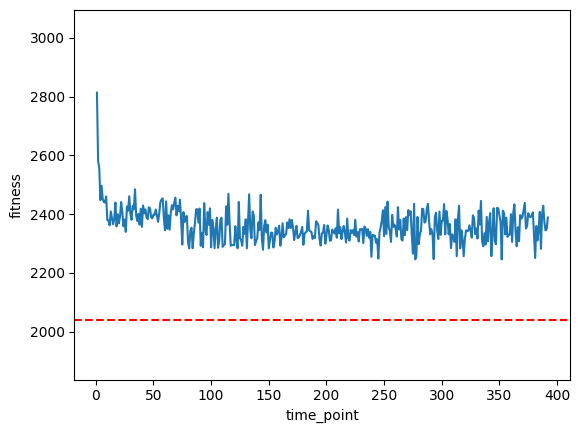

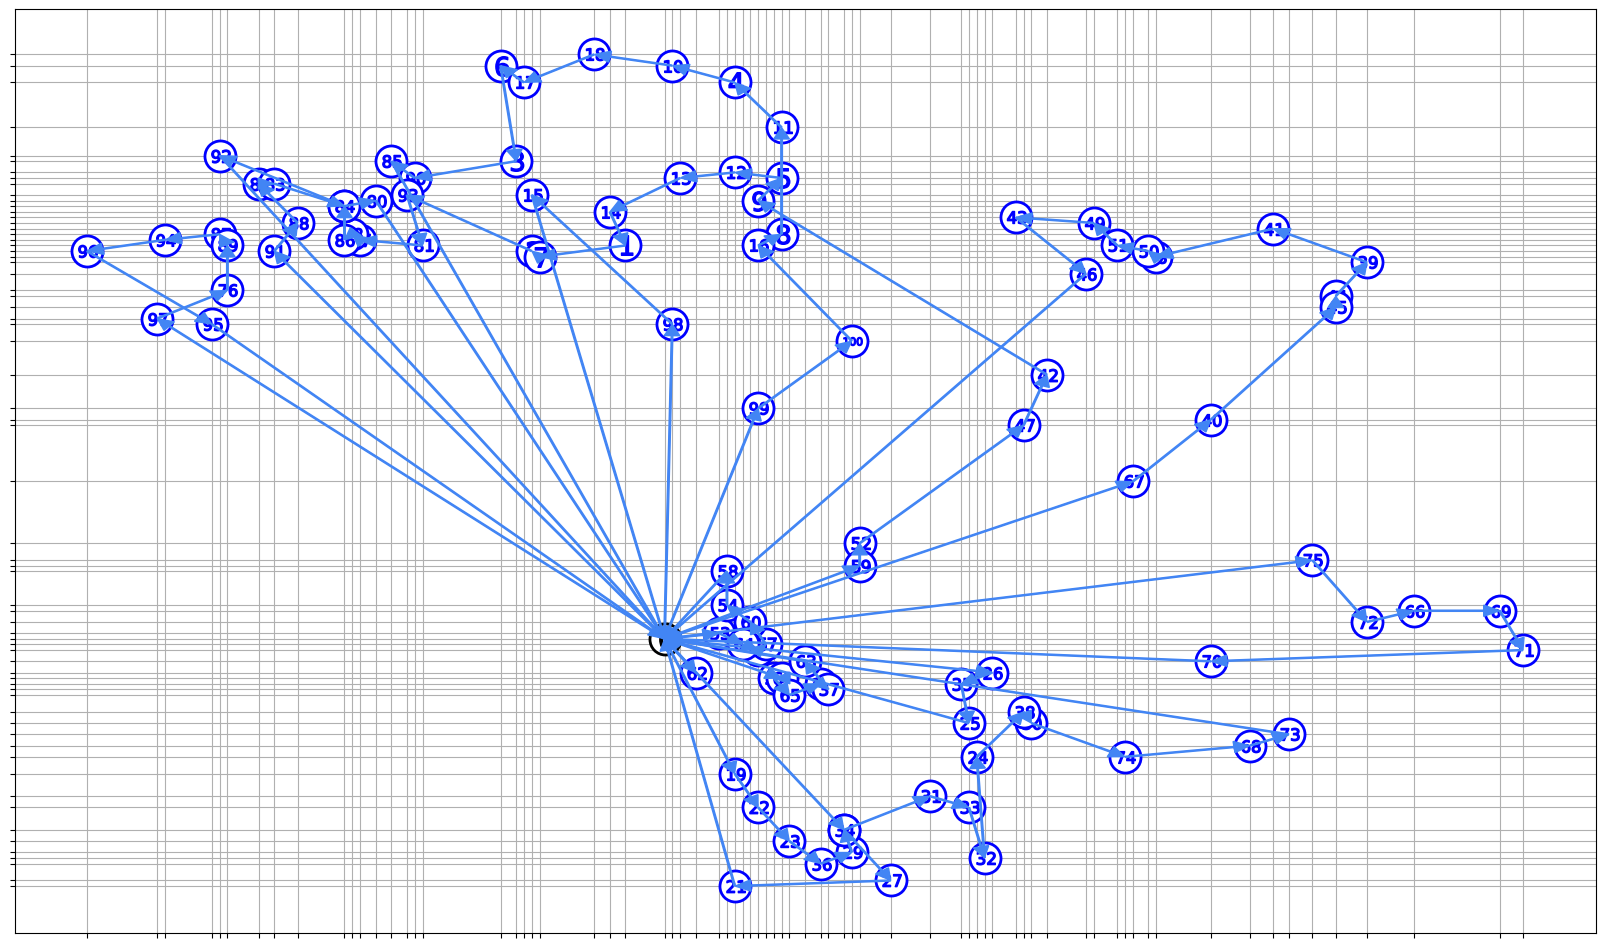

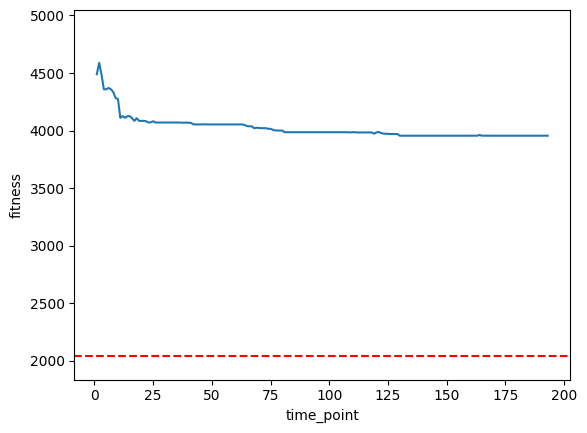

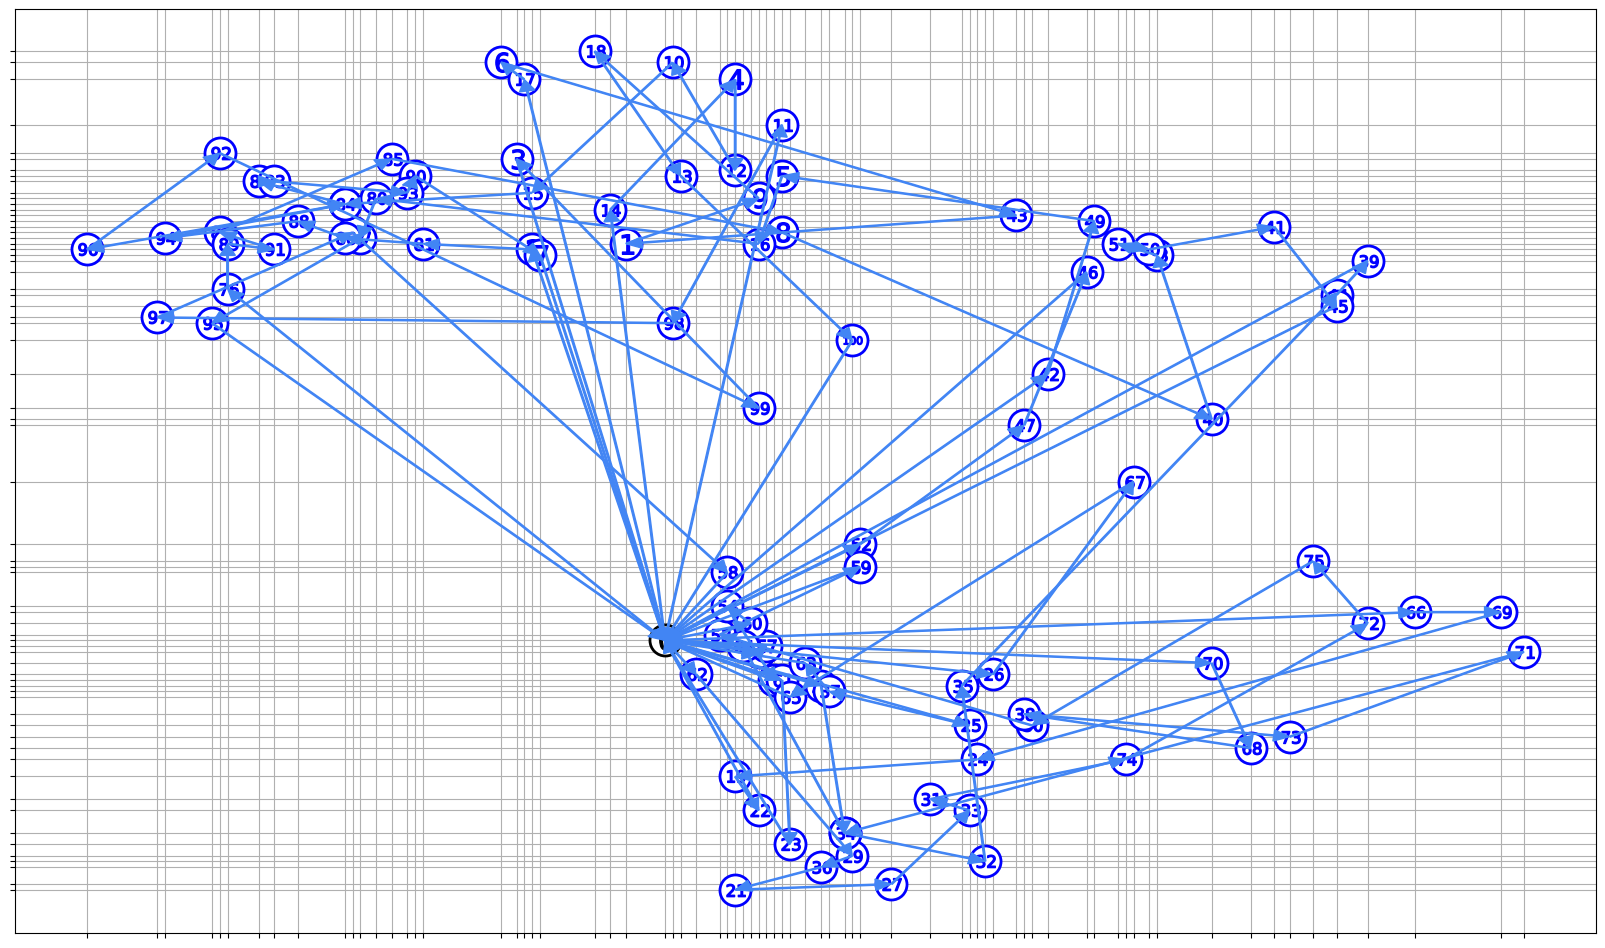

In [7]:
for trial, ant_system in enumerate(as_trials):
    if as_study.get_trials()[trial].state == optuna.trial.TrialState.PRUNED:
        continue
   
    # plot training
    try:
        stats_df = ant_system.fitness_df()
    except ValueError:
        print(f"Error in Trial {trial}")
        continue
    
    fig, ax = plt.subplots()
    chart = sns.lineplot(data=stats_df, x='time_point', y='fitness', ax=ax)
    ax.set_ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
    chart.axhline(best_solution_cost, color='red', linestyle='--')
    fig.savefig(f"./plots/vrp/vrp_as_{trial}.pdf")
    fig.savefig(f"./plots/vrp/vrp_as_{trial}.png")
    fig.show()

    # plot paths
    best_path = ant_system.best_path
    single_path = best_path + [0]
    fig = plot_solution(coordinates, single_path)
    fig.savefig(f"./plots/vrp/vrp_as_{trial}_path.pdf")
    fig.savefig(f"./plots/vrp/vrp_as_{trial}_path.png")
    fig.show()

In [ ]:
stats_df = ant_system.fitness_df()

chart = sns.lineplot(data=stats_df, x='time_point', y='fitness')
plt.ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(best_solution_cost, color='red', linestyle='--')
plt.show()

In [5]:
ant_system._fitness_all_ants[ant_system._top_ant]

1302.795370918408

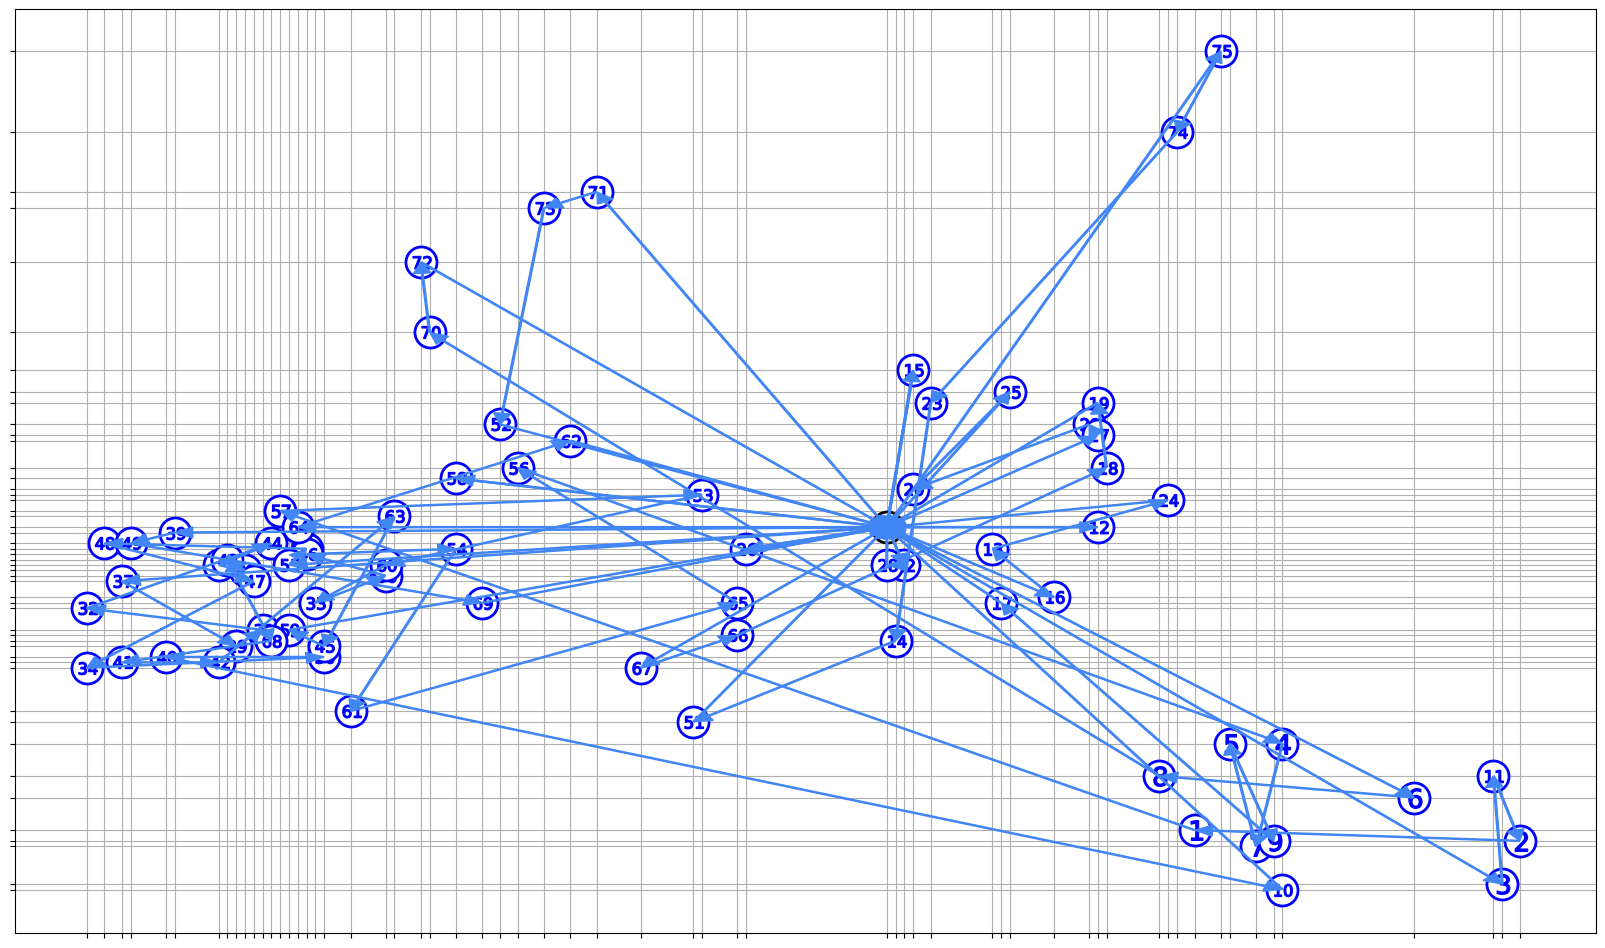

In [3]:
fig = plot_solution(coordinates, ant_system.best_path)